In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype as Category
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
import numpy as np
from iterextras import par_for
import subprocess as sp
import os
import itertools
from tqdm.auto import tqdm
import rs_utils
from scipy.stats import gmean
import matplotlib as mpl
import json
import statsmodels.formula.api as sm
from matplotlib import rc

sns.set()

In [2]:
PATHS = glob('../data/*.json')
CRATES = [os.path.splitext(os.path.basename(path))[0] for path in PATHS]
crate_cat = Category(sorted(CRATES))

def parse_data(path):
    print(path)
    if os.stat(path).st_size == 0:
        return []
    
    crate = os.path.splitext(os.path.basename(path))[0]
    df = pd.read_json(path)
    df['crate'] = crate
    df['crate'] = df['crate'].astype(crate_cat)
    return df


df = pd.concat(par_for(parse_data, PATHS)).reset_index()
df['ins_frac'] = df.num_relevant_instructions / df.num_instructions

../data/rav1e.json
../data/hyper.json
../data/image.json
../data/RustPython.json
../data/rg3d.json
../data/rayon.json
../data/rustls.json
../data/Rocket.json
../data/nalgebra.json
../data/sccache.json


  0%|          | 0/10 [00:00<?, ?it/s]

# Dataset (Section 5.1)

## Crate information (Table 1)

In [3]:
CRATE_INFO = [
    ('Rocket', 'core/lib', 'Web backend framework', 'https://github.com/SergioBenitez/Rocket'),
    ('image', None, 'Image processing library', 'https://github.com/image-rs/image'),
    ('rayon', None, 'Data parallelism library', 'https://github.com/rayon-rs/rayon'),
    ('rg3d', None, '3D game engine', 'https://github.com/mrDIMAS/rg3d'),    
    ('nalgebra', None, 'Numerics library', 'https://github.com/dimforge/nalgebra'),
    ('rustls', 'rustls', 'TLS implementation', 'https://github.com/ctz/rustls'),
    ('sccache', None, 'Distributed build cache', 'https://github.com/mozilla/sccache'),
    ('hyper', None, 'HTTP server', 'https://github.com/hyperium/hyper'),    
    ('rav1e', None, 'Video encoder', 'https://github.com/xiph/rav1e'),
    ('RustPython', 'vm', 'Python interpreter', 'https://github.com/RustPython/RustPython'),
]

In [4]:
df_funcs = df.groupby(['crate', 'function_path']) \
    .apply(lambda df: df.iloc[0]).reset_index(drop=True)
num_slices = df.groupby(['crate']).size().rename('num_slices')
avg_ins_per_func = df_funcs.groupby('crate').num_instructions.mean() \
    .rename('avg_ins_per_func')
num_funcs = df.groupby(['crate']).apply(lambda df: len(df.function_path.unique())).rename('num_funcs')

q = df.groupby(['crate', 'function_path']).size()
avg_slices_per_func = q[q > 0] \
    .groupby('crate').mean().rename('avg_slices_per_func')
crate_stats = pd.concat(
    [num_slices, avg_ins_per_func, num_funcs, avg_slices_per_func], 
    axis=1).sort_values('num_slices')
crate_stats

,num_slices,avg_ins_per_func,num_funcs,avg_slices_per_func
crate,,,,
rayon,27372,16.558333,1080,25.344444
Rocket,32757,25.527665,741,44.206478
rustls,65907,42.447005,868,75.929724
sccache,67404,62.212733,644,104.664596
nalgebra,98856,26.671148,1785,55.381513
image,116340,56.702457,1099,105.859873
hyper,136092,82.887342,790,172.268354
rg3d,167094,25.713167,3448,48.461137
rav1e,228237,115.366273,931,245.152524


In [5]:
CLOC = '/home/wcrichto/.node_modules/bin/cloc'
crate_loc = []
for (crate, path, purpose, url) in CRATE_INFO:
    crate_dir = f'../data/repos/{crate}'
    if path:
        crate_dir += f'/{path}'
    crate_dir += '/src'    
    cloc_str = sp.check_output(f'{CLOC} {crate_dir} --json', shell=True).strip()
    commit = sp.check_output('git rev-parse HEAD', shell=True, cwd=crate_dir).strip().decode('utf-8')
    cloc = json.loads(cloc_str)
    crate_loc.append({
        "crate": crate,
        'subdir': path,
        'purpose': purpose,
        "url": url,
        "commit": commit,
        "loc": cloc["Rust"]["code"],
    })
crate_loc = pd.DataFrame(crate_loc)

In [6]:
crate_final = crate_stats.join(crate_loc.set_index("crate")).sort_values('num_slices')
for crate, row in  crate_final.iterrows():
    print(f'\href{{{row.url}}}{{{crate}}} & {row.subdir or ""} & {row.purpose} & {row["loc"]:,} & \
{row.num_slices:,} & {row.num_funcs:,} & {row.avg_ins_per_func:.1f} \\\\ \hline')

\href{https://github.com/rayon-rs/rayon}{rayon} &  & Data parallelism library & 15,524 & 27,372 & 1,080 & 16.6 \\ \hline
\href{https://github.com/SergioBenitez/Rocket}{Rocket} & core/lib & Web backend framework & 9,313 & 32,757 & 741 & 25.5 \\ \hline
\href{https://github.com/ctz/rustls}{rustls} & rustls & TLS implementation & 16,866 & 65,907 & 868 & 42.4 \\ \hline
\href{https://github.com/mozilla/sccache}{sccache} &  & Distributed build cache & 23,202 & 67,404 & 644 & 62.2 \\ \hline
\href{https://github.com/dimforge/nalgebra}{nalgebra} &  & Numerics library & 31,951 & 98,856 & 1,785 & 26.7 \\ \hline
\href{https://github.com/image-rs/image}{image} &  & Image processing library & 20,722 & 116,340 & 1,099 & 56.7 \\ \hline
\href{https://github.com/hyperium/hyper}{hyper} &  & HTTP server & 15,082 & 136,092 & 790 & 82.9 \\ \hline
\href{https://github.com/mrDIMAS/rg3d}{rg3d} &  & 3D game engine & 54,426 & 167,094 & 3,448 & 25.7 \\ \hline
\href{https://github.com/xiph/rav1e}{rav1e} &  & Video 

In [7]:
print(f'{crate_final["loc"].sum():,} & {crate_final.num_slices.sum():,} & {crate_final.num_funcs.sum():,}')

285,307 & 1,215,951 & 14,714


In [8]:
crate_final.reset_index()[['crate', 'commit']]

,crate,commit
0,rayon,c571f8ffb4f74c8c09b4e1e6d9979b71b4414d07
1,Rocket,8d4d01106e2e10b08100805d40bfa19a7357e900
2,rustls,cdf1dada21a537e141d0c6dde9c5685bb43fbc0e
3,sccache,3f318a8675e4c3de4f5e8ab2d086189f2ae5f5cf
4,nalgebra,984bb1a63943aa68b6f26ff4a6acf8f68b833b70
5,image,e916e9dda5f4253f6cc4557b0fe5fa3876ac18e5
6,hyper,ed2fdb7b6a2963cea7577df05ddc41c56fee7246
7,rg3d,ca7b85f2b30e45b82caee0591ee1abf65bb3eb00
8,rav1e,1b6643324752785e7cd6ad0b19257f3c3a9b2c6a
9,RustPython,9143e51b7524a5084d5ed230b1f2f5b0610ac58b


## Execution time (last paragraph of 5.1)

In [9]:
df.duration.median() * 1e3

4.188585


# Quantitative analysis (Section 5.2)

In [10]:
df.groupby('direction').ins_frac.median()

direction
backward    0.126050
both        0.300000
forward     0.097561
Name: ins_frac, dtype: float64

<AxesSubplot:xlabel='ins_frac', ylabel='direction'>

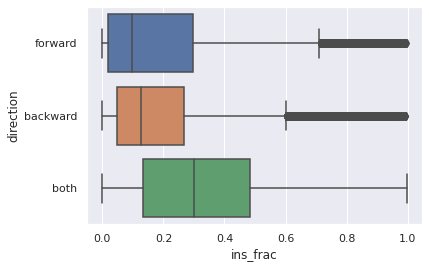

In [11]:
sns.boxplot(data=df, x='ins_frac', y='direction')

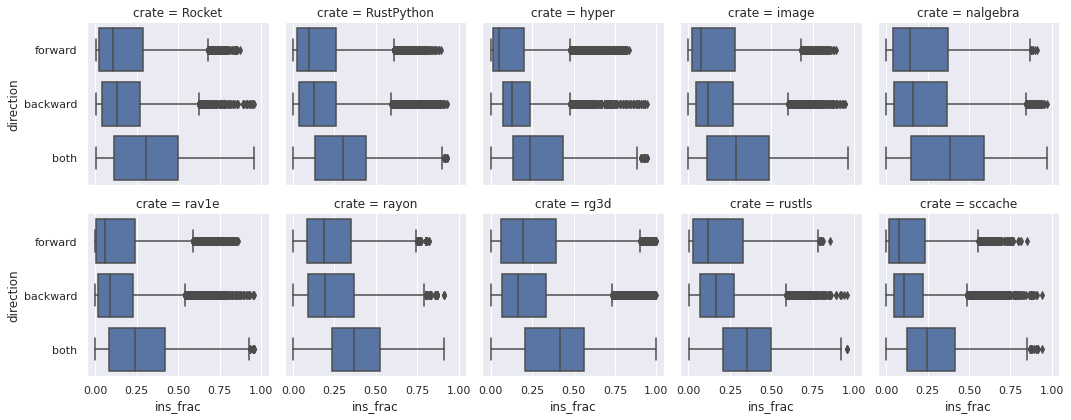

In [12]:
g = sns.FacetGrid(data=df, col='crate', col_wrap=5)
g.map_dataframe(sns.boxplot, x='ins_frac', y='direction')